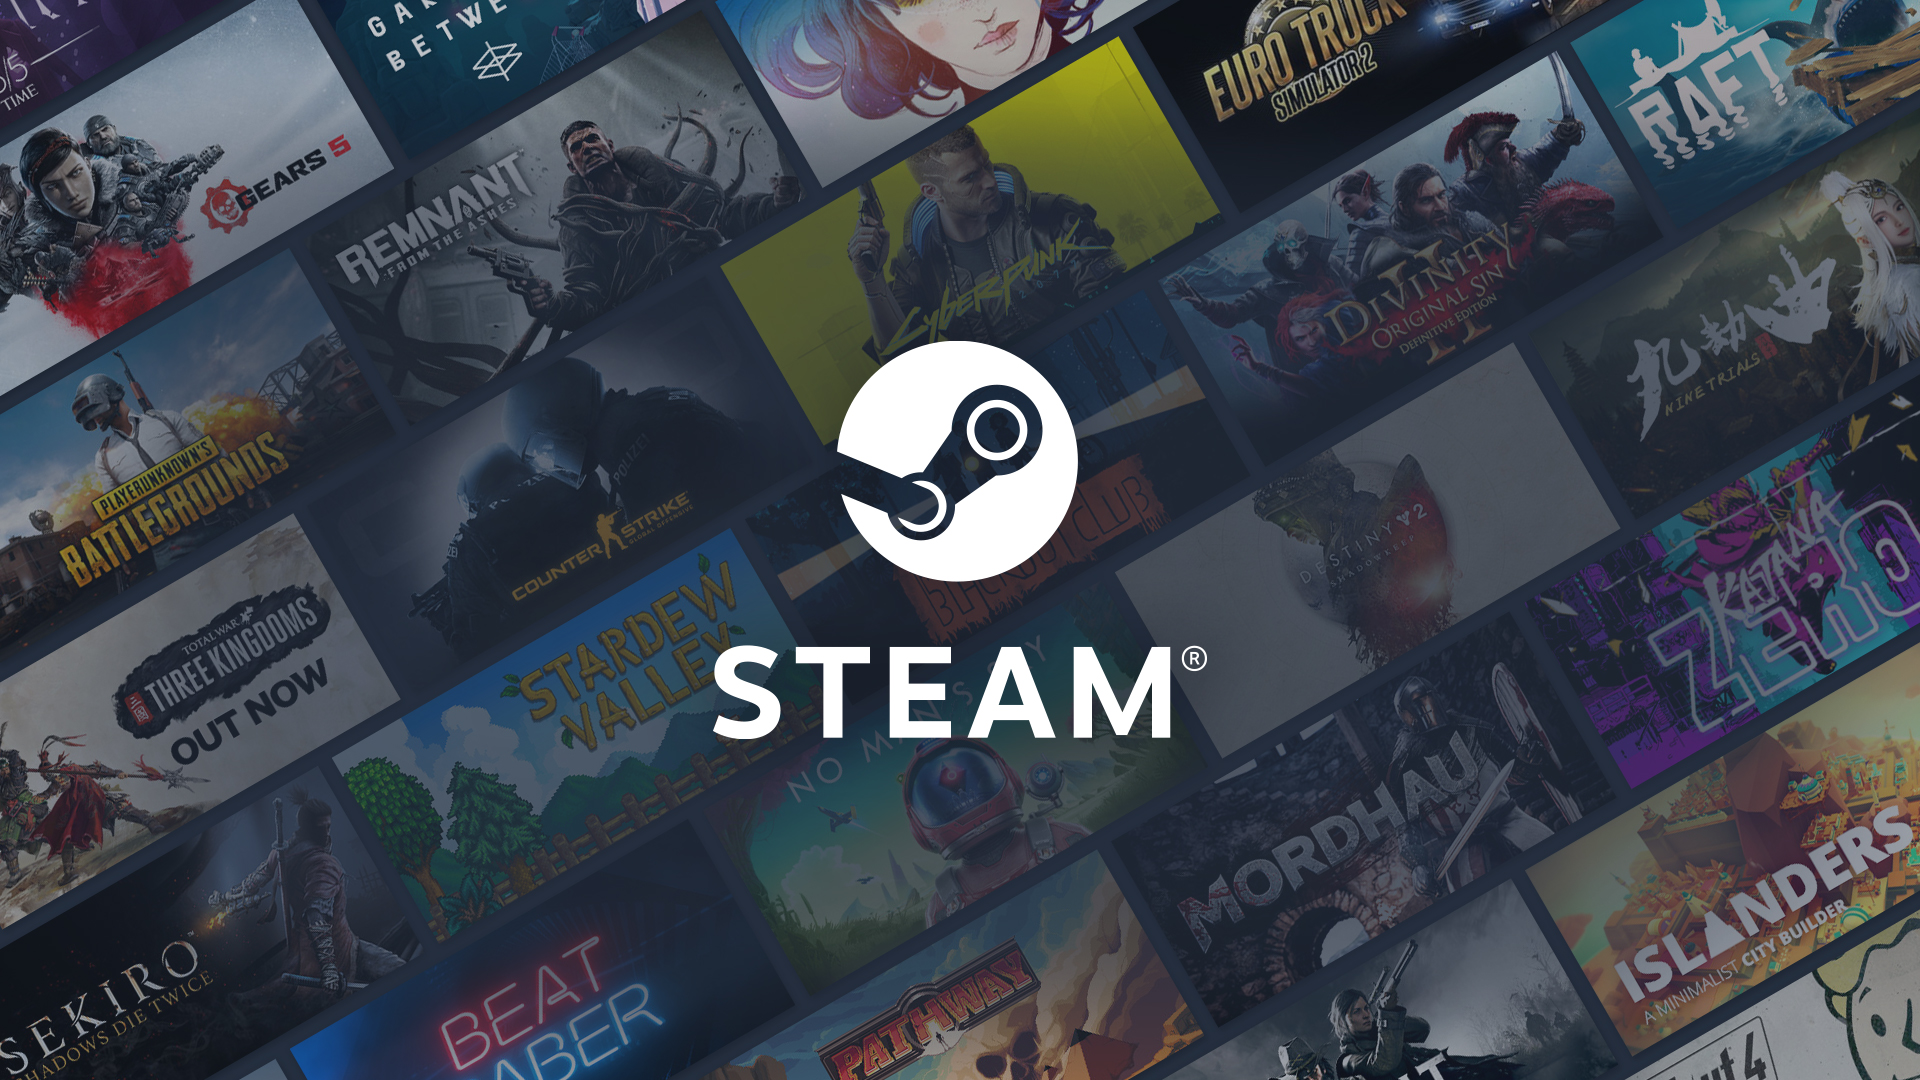

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
data_reviews = pd.DataFrame(data_reviews)

**Games**

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [16]:
data_reviews.to_csv("data_reviews.csv")
data_games.to_csv("data_games.csv")

#### El proyecto consta de las siguientes etapas

    1-Importacion y estado de salud del dataset
    
    2- EDA & Transformacion de datos
        a.Tratamiento de valores faltantes
        b.Detección y eliminación de Outliers
    
    3- Implementacion de modelos de recomendacion
        a-Normal predictor: Modelo benchmark 
        b.SVD
        c.SVDpp
        d.CoClustering
        
    4- Recomendacion de videojuegos
        a.Recomendaciones por usuario
        b.Recomendaciones por videojuego
        
    5- Proximos pasos

# 1- Importación y estado de salud del dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funpymodeling.exploratory import status,freq_tbl,profiling_num,cat_vars, num_vars,corr_pair
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import BaselineOnly,SVD,SVDpp,KNNBaseline,KNNBasic,KNNWithMeans, KNNWithZScore,CoClustering,NormalPredictor
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import RandomizedSearchCV
from tqdm import tqdm

In [2]:
data_reviews = pd.read_csv("data_reviews.csv")
data_games = pd.read_csv("data_games.csv")

In [3]:
status(data_games)

variable  q_nan     p_nan  q_zeros   p_zeros  unique     type
0       Unnamed: 0      0  0.000000        1  0.000031   32135    int64
1        publisher   8062  0.250879        0  0.000000    8237   object
2           genres   3283  0.102163        0  0.000000     883   object
3         app_name      2  0.000062        0  0.000000   32094   object
4            title   2050  0.063793        0  0.000000   30054   object
5              url      0  0.000000        0  0.000000   32135   object
6     release_date   2067  0.064322        0  0.000000    3582   object
7             tags    163  0.005072        0  0.000000   15395   object
8   discount_price  31910  0.992998        0  0.000000      82  float64
9      reviews_url      2  0.000062        0  0.000000   32132   object
10           specs    670  0.020850        0  0.000000    4649   object
11           price   1377  0.042850        0  0.000000     162   object
12    early_access      0  0.000000    30188  0.939412       2     bool
13              id      2  0.000062        0  0.000000   32132  float64
14       developer   3299  0.102661        0  0.000000   10992   object
15       sentiment   7182  0.223495        0  0.000000      18   object
16       metascore  29528  0.918874        0  0.000000      70  float64

In [4]:
data_games.head(4)

Unnamed: 0         publisher  \
0           0         Kotoshiro   
1           1  Making Fun, Inc.   
2           2      Poolians.com   
3           3              彼岸领域   

                                              genres                 app_name  \
0  ['Action', 'Casual', 'Indie', 'Simulation', 'S...      Lost Summoner Kitty   
1       ['Free to Play', 'Indie', 'RPG', 'Strategy']                Ironbound   
2  ['Casual', 'Free to Play', 'Indie', 'Simulatio...  Real Pool 3D - Poolians   
3                  ['Action', 'Adventure', 'Casual']                  弹炸人2222   

                     title                                                url  \
0      Lost Summoner Kitty  http://store.steampowered.com/app/761140/Lost_...   
1                Ironbound  http://store.steampowered.com/app/643980/Ironb...   
2  Real Pool 3D - Poolians  http://store.steampowered.com/app/670290/Real_...   
3                  弹炸人2222     http://store.steampowered.com/app/767400/2222/   

  release_date                                               tags  \
0   2018-01-04  ['Strategy', 'Action', 'Indie', 'Casual', 'Sim...   
1   2018-01-04  ['Free to Play', 'Strategy', 'Indie', 'RPG', '...   
2   2017-07-24  ['Free to Play', 'Simulation', 'Sports', 'Casu...   
3   2017-12-07                  ['Action', 'Adventure', 'Casual']   

   discount_price                                        reviews_url  \
0            4.49  http://steamcommunity.com/app/761140/reviews/?...   
1             NaN  http://steamcommunity.com/app/643980/reviews/?...   
2             NaN  http://steamcommunity.com/app/670290/reviews/?...   
3            0.83  http://steamcommunity.com/app/767400/reviews/?...   

                                               specs         price  \
0                                  ['Single-player']          4.99   
1  ['Single-player', 'Multi-player', 'Online Mult...  Free To Play   
2  ['Single-player', 'Multi-player', 'Online Mult...  Free to Play   
3                                  ['Single-player']          0.99   

   early_access        id         developer        sentiment  metascore  
0         False  761140.0         Kotoshiro              NaN        NaN  
1         False  643980.0  Secret Level SRL  Mostly Positive        NaN  
2         False  670290.0      Poolians.com  Mostly Positive        NaN  
3         False  767400.0              彼岸领域              NaN        NaN

In [3]:
print (f"El dataset contiene {data_reviews.shape[0]} filas y {data_reviews.shape[1]} columnas")

El dataset contiene 779307 filas y 13 columnas


In [4]:
data_reviews.head(2)

Unnamed: 0     username  hours  products  product_id  page_order  \
0           0  Chaos Syren    0.1      41.0      725280           0   
1           1      Ariman1   13.2    1386.0      328100           2   

         date                                               text  \
0  2017-12-17  This would not be acceptable as an entertainme...   
1  2017-08-02  Addictive RPG ! Works fine on linux though it ...   

   early_access  page  user_id compensation  found_funny  
0         False     1      NaN          NaN          NaN  
1         False     1      NaN          NaN          NaN

Con la funcion status podemos observar todas las variables que contiene el dataset, que tipos de datos son y la proporcion de nulos y ceros en cada una de las variables

In [5]:
status(data_reviews)

variable   q_nan     p_nan  q_zeros   p_zeros  unique     type
0     Unnamed: 0       0  0.000000        1  0.000001  779307    int64
1       username      18  0.000023        0  0.000000  540338   object
2          hours    2637  0.003384      459  0.000589   21762  float64
3       products    1566  0.002009        0  0.000000    3926  float64
4     product_id       0  0.000000        0  0.000000   12665    int64
5     page_order       0  0.000000    80557  0.103370      10    int64
6           date       0  0.000000        0  0.000000    2617   object
7           text    1839  0.002360        0  0.000000  718776   object
8   early_access       0  0.000000   671616  0.861812       2     bool
9           page       0  0.000000        0  0.000000   18368    int64
10       user_id  461967  0.592792        0  0.000000  259975  float64
11  compensation  764719  0.981281        0  0.000000       1   object
12   found_funny  659143  0.845807        0  0.000000     634  float64

# 2- EDA & Transformacion de datos

Para poder armar la matriz de utilidad con el formato [user id, item id, ranking] vamos a profundizar el EDA en las siguientes variables:
+ hours (ranking)
+ username (user id)
+ product id (item id)

Hacemos una copia del dataset para poder hacer la transformacion de datos

In [6]:
data_reviews2 = data_reviews.copy()

Eliminamos los valores nulos de la variable hours y username

In [7]:
data_reviews2.dropna(subset=['hours','username'], inplace = True)

Observamos los estadisticos principales de las variables numericas del dataset

In [8]:
data_reviews.describe()

Unnamed: 0          hours       products     product_id  \
count  779307.000000  776670.000000  777741.000000  779307.000000   
mean   389653.000000     111.843832     236.993936  251489.822053   
std    224966.697453     390.145376     486.034479  149975.370469   
min         0.000000       0.000000       1.000000      10.000000   
25%    194826.500000       4.000000      45.000000  203770.000000   
50%    389653.000000      15.300000     110.000000  252490.000000   
75%    584479.500000      59.600000     246.000000  346110.000000   
max    779306.000000   28164.000000   13540.000000  773900.000000   

          page_order           page       user_id    found_funny  
count  779307.000000  779307.000000  3.173400e+05  120164.000000  
mean        4.417743     893.581355  7.656120e+16       7.713125  
std         2.897848    1928.272966  1.007694e+08      72.465816  
min         0.000000       1.000000  7.656120e+16       1.000000  
25%         2.000000      53.000000  7.656120e+16       1.000000  
50%         4.000000     238.000000  7.656120e+16       1.000000  
75%         7.000000     829.000000  7.656120e+16       3.000000  
max         9.000000   18371.000000  7.656120e+16    6524.000000

Graficamos un histograma de la variable hours

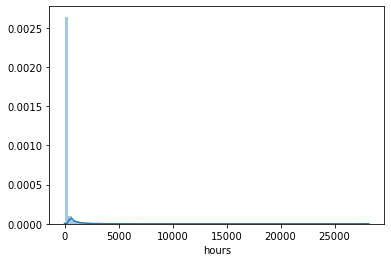

In [9]:
sns.distplot(data_reviews['hours'], bins =80 , rug=False, hist=True, kde = True)
#plt.title("Histograma con la edad de los pasajeros")
plt.show()

Podemos observar que la variable hours tiene valores extremos, es por esto que haremos dos transformaciones:
+ Se mantendran aquellas reviews de los usuarios que hayan jugado más de una hora al juego en cuestion
+ Todos aquellos valores que esten por encima del p0,95, vamos a asignarle este valor (510.4)

In [10]:
data_reviews2["hours_new"] = 0
data_reviews2["hours_new"] = np.where(data_reviews2["hours"] > 510.4, 510.4, data_reviews2["hours"])
data_reviews2 = data_reviews2[data_reviews2["hours"] >= 1]

Si volvemos a graficar un histograma de la variable hours, podemos observar como se redujeron los valores extremos

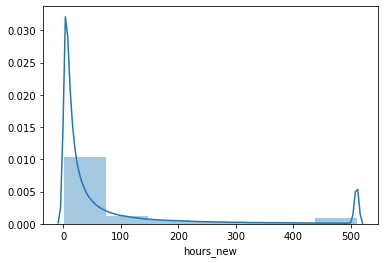

In [11]:
sns.distplot(data_reviews2['hours_new'], bins =7 , rug=False, hist=True, kde = True)
#plt.title("Histograma con la edad de los pasajeros")
plt.show()

In [21]:
data_reviews2.drop(columns = "hours",inplace = True )

Para armar la variable ranking, vamos a utilizar la cantidad de horas jugadas de cada usuario en cada juego para asignar un valor de 1 (mas bajo) a 5 (mas alto). Para realizar esto, vamos a probar con dos enfoques y luego elegiremos el mas conveniente:
+ Pandas cut: Se separan los valores de manera uniforme
+ Pandas qcut: Se separan los valores de manera que cada uno de los bins tengan la misma frecuencia

In [12]:
data_reviews2["Ranking"] = pd.cut(data_reviews2["hours_new"],5,labels=["1", "2", "3","4","5"])
data_reviews2["Ranking2"] = pd.qcut(data_reviews2["hours_new"],5,labels=["1", "2", "3","4","5"])

<AxesSubplot:xlabel='Ranking', ylabel='count'>

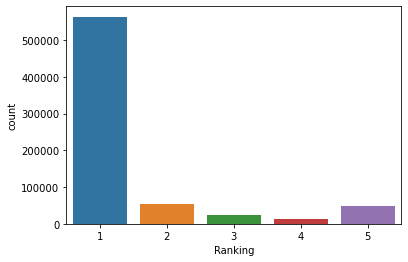

In [13]:
sns.countplot(data=data_reviews2, x="Ranking" )

In [14]:
freq_tbl(data_reviews2["Ranking"])

Ranking  frequency  percentage  cumulative_perc
0       1     563938    0.802776         0.802776
1       2      53252    0.075805         0.878581
2       5      47750    0.067973         0.946554
3       3      23518    0.033478         0.980032
4       4      14027    0.019968         1.000000

<AxesSubplot:xlabel='Ranking2', ylabel='count'>

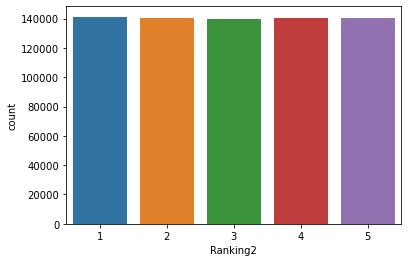

In [15]:
sns.countplot(data=data_reviews2, x="Ranking2" )

In [16]:
freq_tbl(data_reviews2["Ranking2"])

Ranking2  frequency  percentage  cumulative_perc
0        1     141319    0.201170         0.201170
1        5     140468    0.199959         0.401129
2        4     140460    0.199947         0.601076
3        2     140249    0.199647         0.800723
4        3     139989    0.199277         1.000000

Observando los resultados del cut, vamos a utilizar el qcut ya que las clases predictoras estan balanceadas. En caso de no hacerlo, es muy probable que el modelo le asigne un 1 a casi todas las predicciones ya que el 80% del dataset tendria ese ranking

Podemos observar que el dataset cuenta con 500107 usuarios unicos que hicieron una review a algun juego

In [17]:
data_reviews2["username"].value_counts()

123                            198
Alex                           172
Chris                          133
Matt                           128
Nick                           125
                              ... 
CtrlAltDefeat                    1
McClonkenbonk                    1
BIG SHAQ csgo500 tradeit.gg      1
dire spider                      1
LambdaCore                       1
Name: username, Length: 500107, dtype: int64

Con pandas, le asignamos un id unico a cada uno de los usuarios

In [18]:
data_reviews2["id_user"] = data_reviews2.groupby(['username']).ngroup()

In [19]:
data_reviews2["id_user"].value_counts()

5046      198
17710     172
60882     133
199780    128
223681    125
         ... 
385535      1
137984      1
133890      1
131843      1
0           1
Name: id_user, Length: 500107, dtype: int64

El dataset contiene 11289 juegos unicos que fueron calificados por algun usuario

In [20]:
data_reviews2["product_id"].value_counts()

440       17966
252490    10029
49520      7263
377160     6998
271590     5890
          ...  
668660        1
418430        1
434790        1
495680        1
333730        1
Name: product_id, Length: 11289, dtype: int64

Creamos el dataset para luego ingresar al modelo

In [21]:
data_recom = data_reviews2[["id_user","product_id","Ranking2"]]

In [22]:
data_recom.head(2)

id_user  product_id Ranking2
1    24908      328100        3
3   323068      631920        2

# 3-Implementacion de modelos de recomendacion

Para evaluar los modelos vamos a utilizar la metrica de RMSE. La razon por la cual se va a utilizar esta metrica es que es similar al MSE en terminos de minimizadores pero los resultados del RMSE son mucho mas interpretables que en el MSE (el MSE al estar el error elevado al cuadrado, no tiene la misma magnitud ni unidades que la variable).

Cuanto mas bajo sea el RMSE, mejores resultados habra generado el modelo. En un caso ideal, el RMSE deberia ser igual a 0

Bibliografia: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

### A - Normal predictor: Modelo benchmark

Creamos el objeto Reader para luego pasar el dataset al formato aceptado por la libreria Surprise

In [23]:
reader = Reader()

In [24]:
data = Dataset.load_from_df(data_recom[["id_user","product_id","Ranking2"]], reader)

Hacemos el train-test split del dataset. Cada uno de los split van a ser utilizados en modelos distintos

In [25]:
trainset, testset = train_test_split(data, test_size=.25)
trainset1, testset1 = train_test_split(data, test_size=.25)
trainset2, testset2 = train_test_split(data, test_size=.25)
trainset3, testset3 = train_test_split(data, test_size=.25)

Creamos el modelo de recomendacion Normal predictor con sus parametros por defecto y lo entrenamos

In [26]:
bench_model= NormalPredictor()
bench_model.fit(trainset)

Hacemos las predicciones y visualizamos el error del modelo

In [27]:
bench_predictions = bench_model.test(testset)

In [28]:
accuracy.rmse(bench_predictions)

RMSE: 1.8719


1.8718999069717839

El modelo benchmark tiene un error promedio cercano a 2 puntos sobre los 5 puntos del ranking

### B - Modelo SVD

Creamos el modelo SVDpp basado en la factorizacion de matrices con sus parametros por defecto y lo entrenamos

In [29]:
model = SVD()

In [30]:
model.fit(trainset1)

Hacemos las predicciones y visualizamos el error del modelo

In [31]:
predictions0 = model.test(testset1)
accuracy.rmse(predictions0)

RMSE: 1.0965


1.0965321318767183

Con solo modificar el modelo, obtuvimos una mejora de en la metrica RMSE del ~41% respecto al modelo benchmark

Vamos a hacer una optimizacion de los hiperparametros a traves de random search

In [42]:
param_grid = {'n_factors': [5,10,15,20,30,50,100],'n_epochs': [5,10,20,25,40,50], 'lr_all': [0.001, 0.002, 0.005, 0.0055, 0.006, 0.007],
              'reg_all': [0.002, 0.02, 0.2, 0.025 ,0.03, 0.04]}
gs = RandomizedSearchCV(SVD, param_grid, n_iter = 15 , measures=['rmse'], cv=5, n_jobs = -1,refit = True)
gs.fit(data)

Observamos cuales son los mejores parametros encontrados, para luego hacer las predicciones

In [43]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.088360283220267
{'n_factors': 5, 'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.04}


Creamos el modelo con los mejores hiperparametros encontrados, entrenamos el modelo y luego hacemos las predicciones

In [32]:
best_model = SVD(n_factors= 30, n_epochs= 50, lr_all= 0.005, reg_all= 0.03)
best_model.fit(trainset1)

In [33]:
predictions = best_model.test(testset1)
accuracy.rmse(predictions)

RMSE: 1.0918


1.091816666519283

La mejora del modelo en terminos de RMSE habiendo mejorado sus hiperparametros es del 0.47%

### C - Modelo SVDpp

Creamos el modelo SVD basado en la factorizacion de matrices (es una extensión de SVD) con sus parametros por defecto y lo entrenamos

In [34]:
modelpp = SVDpp()

In [35]:
modelpp.fit(trainset2)

Hacemos las predicciones y visualizamos el error del modelo

In [36]:
predictionspp0 = modelpp.test(testset2)
accuracy.rmse(predictionspp0)

RMSE: 1.1503


1.1503368088359247

El error del modelo en terminos de RMSE es levemente más alto que en el modelo SVD, siendo 1,1 puntos

Vamos a hacer una optimizacion de los hiperparametros a traves de random search

In [49]:
param_grid = {'n_factors': [5,10,15,20,30,50,100],'n_epochs': [5,10,20,25,40,50], 'lr_all': [0.001, 0.002, 0.005, 0.0055, 0.006, 0.007],
              'reg_all': [0.002,0.02, 0.2, 0.025 ,0.03, 0.04]}
rs_pp = RandomizedSearchCV(SVDpp, param_grid, n_iter = 15 , measures=['rmse'], cv=5, n_jobs = -1,refit = True)
rs_pp.fit(data)

Observamos cuales son los mejores parametros encontrados, para luego hacer las predicciones

In [50]:
print(rs_pp.best_score['rmse'])
print(rs_pp.best_params['rmse'])

1.1086988301026948
{'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.006, 'reg_all': 0.03}


Creamos el modelo con los mejores hiperparametros encontrados, entrenamos el modelo y luego hacemos las predicciones

In [37]:
best_modelpp = SVDpp(n_factors= 5, n_epochs= 10, lr_all= 0.006, reg_all= 0.04)
best_modelpp.fit(trainset2)

In [38]:
predictionspp = best_modelpp.test(testset2)
accuracy.rmse(predictionspp)

RMSE: 1.1051


1.1051060380371176

Si bien con la optimizacion de los hiperparametros mejoro el resultado del modelo, en terminos de RMSE sigue siendo levemente mas elevado que el modelo de SVD

### D -  Modelo CoClustering

Creamos el modelo CoClustering basado en la agrupacion de clusters con sus parametros por defecto y lo entrenamos

In [53]:
modelclt = CoClustering ()

In [54]:
modelclt.fit(trainset3)

Hacemos las predicciones y visualizamos el error del modelo

In [55]:
predictionsclt = modelclt.test(testset3)

In [56]:
accuracy.rmse(predictionsclt)

RMSE: 1.4041


1.4040914796763446

Con sus hiperparametros por defecto, este modelo obtuvo un RMSE más elevado que en el resto de los modelos

Vamos a hacer una optimizacion de los hiperparametros a traves de random search

In [57]:
param_grid = {'n_cltr_u': [2,3,4,5,8,10],'n_cltr_i': [2,3,4,5,8,10,20,30],'n_epochs': [5,10,20,25,40,50]}
rs_cc = RandomizedSearchCV(CoClustering, param_grid, n_iter = 15 , measures=['rmse'], cv=5, n_jobs = -1,refit = True)
rs_cc.fit(data)

Observamos cuales son los mejores parametros encontrados, para luego hacer las predicciones

In [58]:
print(rs_cc.best_score['rmse'])
print(rs_cc.best_params['rmse'])

1.3847410739516408
{'n_cltr_u': 10, 'n_cltr_i': 10, 'n_epochs': 10}


Creamos el modelo con los mejores hiperparametros encontrados, entrenamos el modelo y luego hacemos las predicciones

In [39]:
best_modelcc = CoClustering(n_cltr_u= 8, n_cltr_i= 8, n_epochs= 50)
best_modelcc.fit(trainset3)

In [40]:
predictionscc = best_modelcc.test(testset3)
accuracy.rmse(predictionscc)

RMSE: 1.3851


1.385142075037542

No se observa una mejora en el RMSE luego de hacer un optimizacion de los hiperparametros

#### Conclusión: Luego de probar 4 modelos distintos, se pudo observar que los mejores resultados son aquellos en los que se implemento la recomendacion a traves de factorizacion de matrices (SVD, SVDpp).
#### Dentro de estos, el mejor modelo fue el implementado con SVD, con un RMSE muy cercano a 1, siendo un 0.5% mas elevado que en el modelo SVDpp.
#### Es por esto que vamos a realizar las recomendaciones con el modelo SVD

# 4- Recomendacion de videojuegos

In [41]:
data_games["product_id"] = data_games["id"]
data_completo = pd.merge(data_recom,data_games, on ="product_id", how = "left" )
data_completo = data_completo[["id_user","product_id","Ranking2","title","genres"]]
data_catalogo = data_completo[["product_id","title","genres"]]
data_catalogo = data_catalogo.drop_duplicates()

## A - Recomendaciones por usuario
    En este caso, se va a pedir que se ingrese por consola un ID de usuario para poder recomendarle los mejores 5 videojuegos
    Algunos usuarios de ejemplo: 5046, 17710.60882,199780,223681

In [46]:
usuario = int(input("¿A qué usuario quiere recomendarle videojuegos?"))

data_nueva = data_completo[data_completo["id_user"] != usuario]
data_nueva2 = data_nueva["product_id"].to_numpy()


rmse = []
for i in tqdm(data_nueva2):
    pred = best_model.predict(usuario,i)
    rmse.append(pred)
    

recomendaciones_user = pd.DataFrame(rmse).sort_values(by="est", ascending= False).drop(columns = "details")
recomendaciones_user = recomendaciones_user.drop_duplicates().head(5)
recomendaciones_user =pd.merge(recomendaciones_user,data_catalogo, left_on ="iid",right_on='product_id', how = "left" )
print ("\nLos mejores 5 videojuegos para recomendar al usuario seleccionado son:\n\n")
recomendaciones_user[["product_id","title","genres","est"]]

¿A qué usuario quiere recomendarle videojuegos? 223681


100%|██████████████████████████████████████████████████████████████████████| 702985/702985 [00:05<00:00, 139487.04it/s]



Los mejores 5 videojuegos para recomendar al usuario seleccionado son:




product_id                           title  \
0      203770               Crusader Kings II   
1      301520                       Robocraft   
2       34030            Napoleon: Total War™   
3      105600                        Terraria   
4      339610  Freestyle 2: Street Basketball   

                                              genres       est  
0                  ['RPG', 'Simulation', 'Strategy']  5.000000  
1  ['Action', 'Free to Play', 'Indie', 'Massively...  5.000000  
2                                       ['Strategy']  5.000000  
3            ['Action', 'Adventure', 'Indie', 'RPG']  4.913015  
4  ['Action', 'Casual', 'Free to Play', 'Massivel...  4.876545

## B - Recomendaciones por videojuego
    En este caso, se va a pedir que se ingrese por consola un ID de producto (videojuego) para poder recomendarle los mejores 5 usuarios
    Algunos videojuegos de ejemplo: 440,252490,49520,377160,271590

In [43]:
juego = int(input("¿Qué videojuego quiere recomendar?\n\n"))

data_nueva_juego = data_completo[data_completo["product_id"] != juego]
data_nueva2_juego = data_nueva_juego["id_user"].to_numpy()


rmse_juegos = []
for i in tqdm(data_nueva2_juego):
    pred2 = best_model.predict(i,juego)
    rmse_juegos.append(pred2)
    

recomendaciones_juego = pd.DataFrame(rmse_juegos).sort_values(by="est", ascending= False).drop(columns = "details")
recomendaciones_juego = recomendaciones_juego.drop_duplicates().head(5)
recomendaciones_juego =pd.merge(recomendaciones_juego,data_catalogo, left_on ="iid",right_on='product_id', how = "left" )
print ("\nEl videojuego seleccionado debe ser recomendado a los siguientes usuarios:\n\n")
recomendaciones_juego[["uid","title","genres","est"]]

¿Qué videojuego quiere recomendar?

 203770


100%|██████████████████████████████████████████████████████████████████████| 701382/701382 [00:05<00:00, 128786.96it/s]



El videojuego seleccionado debe ser recomendado a los siguientes usuarios:




uid              title                             genres  est
0   59490  Crusader Kings II  ['RPG', 'Simulation', 'Strategy']  5.0
1  309164  Crusader Kings II  ['RPG', 'Simulation', 'Strategy']  5.0
2   44986  Crusader Kings II  ['RPG', 'Simulation', 'Strategy']  5.0
3  384843  Crusader Kings II  ['RPG', 'Simulation', 'Strategy']  5.0
4  432887  Crusader Kings II  ['RPG', 'Simulation', 'Strategy']  5.0

# 5- Proximos pasos

#### Si bien los resultados del modelo implementado fueron buenos creo que podria haber una mejora si modificamos el enfoque actual. Esto se podria aperturar en dos ramas distintas:

+ 1- Recomendacion a usuarios (filtro colaborativo): Si bien ya se implemento esto con Surprise, creo que puede haber un diferencial en el RMSE si se implementa con una red neuronal, donde la ultima neurona tenga la funcion de predecir el ranking de el videojuego para determinado usuario (Neurona Softmax). Para esto, los resultados que espero obtener es una mejora del RMSE de por lo menos un 10%, tanto por usar un modelo mas robusto como tambien, porque agregaria informacion adicional de los videojuegos.

+ 2-Recomendacion de items (Basado en contenidos): Este es un enfoque que no se tuvo en cuenta en el proyecto actual. Para realizar esto, tambien hay que agregar informacion adicional de los videojuegos, como por ejemplo el genero, y luego entrenar una red neuronal. Se recomendarian los items a base a alguna metrica para encontrar items similares como por ejemplo el indice de jaccard. El resultado de este modelo es la recomendacion de los 5 items mas parecidos entre si.

#### Seria interesante tambien, crear redes neuronales con distinta arquitectura, por ejemplo:

+ 1- Una red neuronal que reciba como input todas las variables predictoras (habiendo aplicado un one hot encoding) y luego que contenga todas capas densas y una ultima capa softmax para clasificar la variable a predecir

+ 2- Una red neuronal que tenga una capa de embedding para realizar una reduccion de dimensionalidad de las capas de entrada. Lo interesante de este enfoque, es que luego de entrenar la red, podremos "pinchar" esta capa de embedding y nos va a permitir entender la similitud de todos los intems